<a href="https://colab.research.google.com/github/Sizerta/Australia-rain-prediction/blob/main/RainPredictionSizerta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
data = '/content/drive/MyDrive/Colab Notebooks/weatherAUS.csv'

df = pd.read_csv(data)

In [6]:
zeros_cnt = df.isnull().sum().sort_values(ascending=False)
percent_zeros = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([zeros_cnt, percent_zeros], axis=1, keys=['Total', 'Percent'])
missing_data
#missing_data.T

,Total,Percent
Sunshine,69835,0.480098
Evaporation,62790,0.431665
Cloud3pm,59358,0.408071
Cloud9am,55888,0.384216
Pressure9am,15065,0.103568
Pressure3pm,15028,0.103314
WindDir9am,10566,0.072639
WindGustDir,10326,0.070989
WindGustSpeed,10263,0.070555
Humidity3pm,4507,0.030984


In [7]:
dropList = list(missing_data[missing_data['Percent'] > 0.15].index)
dropList
df.drop(dropList, axis=1, inplace=True)

In [8]:
df.head()
df.drop(['Date'], axis=1, inplace=True)
df.drop(['Location'], axis=1, inplace=True)


In [9]:
ohe = pd.get_dummies(data=df, columns=['WindGustDir','WindDir9am','WindDir3pm'])
ohe.info()
from sklearn import preprocessing
from numpy import array

ohe['RainToday'] = df['RainToday'].astype(str)
ohe['RainTomorrow'] = df['RainTomorrow'].astype(str)

lb = preprocessing.LabelBinarizer()

ohe['RainToday'] = lb.fit_transform(ohe['RainToday'])
ohe['RainTomorrow'] = lb.fit_transform(ohe['RainTomorrow'])
ohe = ohe.dropna()
#ohe.drop('Location', axis=1, inplace=True)
y = ohe['RainTomorrow']
X = ohe.drop(['RainTomorrow'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 62 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   MinTemp          143975 non-null  float64
 1   MaxTemp          144199 non-null  float64
 2   Rainfall         142199 non-null  float64
 3   WindGustSpeed    135197 non-null  float64
 4   WindSpeed9am     143693 non-null  float64
 5   WindSpeed3pm     142398 non-null  float64
 6   Humidity9am      142806 non-null  float64
 7   Humidity3pm      140953 non-null  float64
 8   Pressure9am      130395 non-null  float64
 9   Pressure3pm      130432 non-null  float64
 10  Temp9am          143693 non-null  float64
 11  Temp3pm          141851 non-null  float64
 12  RainToday        142199 non-null  object 
 13  RainTomorrow     142193 non-null  object 
 14  WindGustDir_E    145460 non-null  uint8  
 15  WindGustDir_ENE  145460 non-null  uint8  
 16  WindGustDir_ESE  145460 non-null  uint

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
pipe = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier(criterion='gini', 
                                                                              max_depth=10, 
                                                                              max_features='auto',
                                                                              n_estimators=200))])

In [17]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('RFC',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [18]:
pipe.score(X_train, y_train)

0.8585075831296134

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X, y, cv=3)

array([0.83250679, 0.84097989, 0.84117926])

In [20]:
y_pred = pipe.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.8474041257095389

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

#recall_score(y_test, y_pred)
#precision_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.907881320518178

No Skill: ROC AUC=0.500
RFC: ROC AUC=0.862


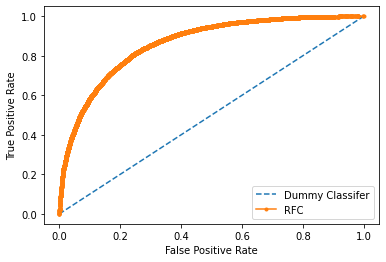

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = pipe.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RFC: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RFC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

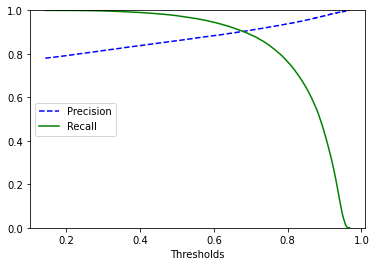

In [23]:
from sklearn.metrics import precision_recall_curve
y_scores = pipe.predict_proba(X_train)[:,1]
#y_scores

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_prc (precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc='center left')
    plt.ylim([0,1])

plot_prc(precisions, recalls, thresholds)

In [24]:
#y_pred = clf.predict(X_test)  # default threshold is 0.5
y_pred1 = (pipe.predict_proba(X_train)[:,1] >= 0.8).astype(int) # set threshold as 0.3
precision_score(y_train, y_pred1)

0.9381189050792575